In [191]:
# %%
import os
import sys
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
from matplotlib.colors import LinearSegmentedColormap
import json
from harp.clock import decode_harp_clock, align_timestamps_to_anchor_points
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import re
from utils.beh_functions import parseSessionID, session_dirs, get_unit_tbl
from utils.plot_utils import shiftedColorMap, template_reorder
from utils.ephys_functions import load_drift
from open_ephys.analysis import Session
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.postprocessing as spost
import spikeinterface.widgets as sw
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
from aind_ephys_utils import align
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colormaps
from aind_dynamic_foraging_data_utils.nwb_utils import load_nwb_from_filename
from spikeinterface.core.sorting_tools import random_spikes_selection
import pickle
import datetime
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
from tqdm import tqdm
import shutil
%matplotlib inline

In [192]:
session = 'behavior_758017_2025-02-06_11-26-14'
data_type = 'curated'
plot = True
session_dir = session_dirs(session)
waveform_zarr_folder = f'{session_dir[f"ephys_dir_{data_type}"]}/waveforms_session.zarr'
analyzer_binned = si.load(waveform_zarr_folder, load_extensions=True)
analyzer = si.load(session_dir[f'postprocessed_dir_{data_type}'], load_extensions=False)

In [193]:
unit_ids = analyzer.sorting.get_unit_ids()
unit_ids_binned = analyzer_binned.sorting.get_unit_ids()
bin_inds = list(set([int(curr_id.split('-')[-1]) for curr_id in unit_ids_binned])) 
all_channels = analyzer.sparsity.channel_ids
if all_channels[0].startswith('AP'):
    all_channels_int = np.array([int(channel.split('AP')[-1]) for channel in all_channels])
else:
    all_channels_int = np.array([int(channel.split('CH')[-1]) for channel in all_channels])
unit_spartsiity = analyzer.sparsity.unit_id_to_channel_ids
channel_locations = analyzer.get_channel_locations()
unit_locations = analyzer.get_extension("unit_locations").get_data(outputs="by_unit")
right_left = channel_locations[:, 0]<20 

In [194]:
session_rec = Session(session_dir['session_dir'])
start = session_rec.recordnodes[0].recordings[0].continuous[0].timestamps[0]
end = session_rec.recordnodes[0].recordings[0].continuous[0].timestamps[-1]

In [195]:
# re-organize templates so that left and right separate
colors = ["blue", "white", "red"]
b_w_r_cmap = LinearSegmentedColormap.from_list("b_w_r", colors)

y_neighbors_to_keep = 3
samples_to_keep = [-30, 60]
orginal_loc = False
waveform_params = {'samples_to_keep': samples_to_keep, 'y_neighbors_to_keep': y_neighbors_to_keep, 'orginal_loc': orginal_loc}
channel_loc_dict = {channel: channel_loc for channel, channel_loc in zip(all_channels_int, channel_locations)}

wf_ext = analyzer_binned.get_extension("waveforms")
temp_ext = analyzer_binned.get_extension("templates")
temp_ext_mean = analyzer.get_extension("templates")

extreme_channel_indices_binned = si.get_template_extremum_channel(analyzer_binned, mode = "at_index", outputs = "index")
extreme_channels_binned = si.get_template_extremum_channel(analyzer_binned) 

extreme_channel_indices = si.get_template_extremum_channel(analyzer, mode = "at_index", outputs = "index")
extreme_channels = si.get_template_extremum_channel(analyzer) 

# recompute extreme channel binned so that they are from the same column
units_in_binned = [unit_id.split('-')[0] for unit_id in unit_ids_binned]
for unit_id in unit_ids:
    curr_peak_ori = extreme_channel_indices[unit_id]
    for curr_bin_ind in bin_inds:
        curr_unit_id = f'{unit_id}-{curr_bin_ind}'
        if curr_unit_id in unit_ids_binned:
            curr_peak_opt = extreme_channel_indices_binned[curr_unit_id]
            if right_left[curr_peak_ori] != right_left[curr_peak_opt]:
                # recompute if changed column
                channel_inds_same_col = np.where(right_left == right_left[curr_peak_ori])[0]
                temp_same = temp_ext.get_unit_template(curr_unit_id, operator='average')[:, channel_inds_same_col]
                peak_ind = np.argmax(np.abs(temp_same[30, :]))
                extreme_channel_indices_binned[curr_unit_id] = channel_inds_same_col[peak_ind]

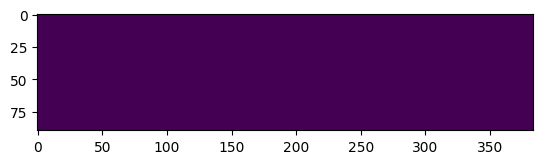

In [209]:
unit_tbl = get_unit_tbl(session, data_type)
all_wfs = []
all_amps_ori = []
all_wfs_ori = []
all_peak_wf = []
all_peak_wf_ori = []
all_counts = np.zeros((len(unit_ids), len(bin_inds)))
presence_score = np.ones((len(unit_ids), len(bin_inds)))
all_units = []
all_tagged_units = unit_tbl.query('opto_pass == True and default_qc == True')['unit_id'].values

for unit_ind, unit_id in enumerate(all_tagged_units):
    curr_wfs_bins = []
    curr_wfs_bins_ori = []
    curr_peak_bins = []
    curr_peak_bins_ori = []
    drift = load_drift(session, unit_id, data_type=data_type)
    temp_mean_curr = temp_ext_mean.get_unit_template(unit_id, operator='average') 
    peak_mean_curr = temp_mean_curr[:,extreme_channel_indices[unit_id]]
    amp_curr = peak_mean_curr[90]
    for curr_ind in bin_inds:
        curr_unit_id = f'{unit_id}-{curr_ind}'
        curr_time_bin = [curr_ind * 10 * 60 + start, (curr_ind + 1) * 10 * 60 + start]
        if drift['ephys_cut'] is not None:
            if drift['ephys_cut'][0] is not None:
                if drift['ephys_cut'][0] > curr_time_bin[0] + 5 * 60:
                    presence_score[unit_ind, curr_ind] = 0
            if drift['ephys_cut'][1] is not None:
                if drift['ephys_cut'][1] < curr_time_bin[1] - 5 * 60:
                    presence_score[unit_ind, curr_ind] = 0
        if curr_unit_id in unit_ids_binned:
            curr_temp = temp_ext.get_unit_template(curr_unit_id, operator='average')
            # curr_std  = temp_ext.get_unit_template(curr_unit_id, operator='std')
            curr_wfs = wf_ext.get_waveforms_one_unit(curr_unit_id)
            all_counts[unit_ind, curr_ind] = len(curr_wfs)
            reordered_template = template_reorder(curr_temp, right_left, all_channels_int, 
                                                sample_to_keep = samples_to_keep, y_neighbors_to_keep = y_neighbors_to_keep, orginal_loc = True, 
                                                peak_ind=extreme_channel_indices_binned[curr_unit_id])
            curr_wfs_bins.append(reordered_template)
            orginal_template = template_reorder(curr_temp, right_left, all_channels_int, 
                                                sample_to_keep = samples_to_keep, y_neighbors_to_keep = y_neighbors_to_keep, orginal_loc = True, 
                                                peak_ind=extreme_channel_indices[unit_id])
            curr_wfs_bins_ori.append(orginal_template)
            curr_peak_bins.append(curr_temp[:, extreme_channel_indices_binned[curr_unit_id]])
            curr_peak_bins_ori.append(curr_temp[:, extreme_channel_indices[unit_id]])
        else:
            curr_wfs_bins.append(np.array([]))
            curr_wfs_bins_ori.append(np.array([]))
            curr_peak_bins.append(np.array([]))
            curr_peak_bins_ori.append(np.array([]))

    non_empty_shape = next(arr.shape for arr in curr_wfs_bins if arr.size > 0)
    curr_wfs_bins = [arr if arr.size > 0 else np.full(non_empty_shape, np.nan) for arr in curr_wfs_bins]
    curr_wfs_bins_ori = [arr if arr.size > 0 else np.full(non_empty_shape, np.nan) for arr in curr_wfs_bins_ori]

    non_empty_shape = next(arr.shape for arr in curr_peak_bins if arr.size > 0)
    curr_peak_bins = [arr if arr.size > 0 else np.full(non_empty_shape, np.nan) for arr in curr_peak_bins]
    curr_peak_bins_ori = [arr if arr.size > 0 else np.full(non_empty_shape, np.nan) for arr in curr_peak_bins_ori]

    all_wfs.append(curr_wfs_bins)  
    all_wfs_ori.append(curr_wfs_bins_ori)
    all_peak_wf.append(curr_peak_bins)
    all_peak_wf_ori.append(curr_peak_bins_ori)
    all_amps_ori.append(amp_curr)


In [207]:
# recompute waveforms
all_peak_wf_opt = []
all_mat_wfs_opt = []
all_amp_opt = []
for unit_ind, unit in enumerate(all_tagged_units):
    mat_wfs = all_wfs[unit_ind]
    peak_wfs = all_peak_wf[unit_ind]
    presence = presence_score[unit_ind]
    count = all_counts[unit_ind]
    # find both presence and count
    if any(p and c > 100 for p, c in zip(presence, count)):
        val_bins = np.where((presence > 0) & (count > 0))[0]
        curr_peaks = np.array([peak_wf[30] if peak_wf.size > 0 else 0 for peak_wf in peak_wfs])
        max_ind = np.argmax(np.abs(curr_peaks[val_bins]))
        unit_amp = curr_peaks[val_bins[max_ind]]
        unit_peak = peak_wfs[val_bins[max_ind]]
        unit_peak_mat = mat_wfs[val_bins[max_ind]]
    elif any(c > 100 for c in count):
        val_bins = np.where(count > 0)[0]
        curr_peaks = np.array([peak_wf[30] for peak_wf in peak_wfs if peak_wf.size > 0])
        max_ind = np.argmax(np.abs(curr_peaks[val_bins]))
        unit_amp = curr_peaks[val_bins[max_ind]]
        unit_peak = peak_wfs[val_bins[max_ind]]
        unit_peak_mat = mat_wfs[val_bins[max_ind]]
    else:
        unit_amp = np.nan
        unit_peak = np.full(len(all_channels_int), np.nan)
        unit_peak_mat = np.full((len(all_channels_int), 2 * y_neighbors_to_keep + 1), np.nan)
    all_amp_opt.append(unit_amp)
    all_peak_wf_opt.append(unit_peak)
    all_mat_wfs_opt.append(unit_peak_mat)

waveform_recompute = pd.DataFrame({'unit_id': all_tagged_units, 'amplitude_opt': all_amp_opt, 'peak_wf_opt': all_peak_wf_opt, 'mat_wf_opt': all_mat_wfs_opt})
unit_tbl = unit_tbl.merge(waveform_recompute, on='unit_id', how='left')
unit_tbl_file = os.path.join(session_dir[f'opto_dir_{data_type}'], f'{session}_{data_type}_soma_opto_tagging_summary.pkl')
# with open(unit_tbl_file, 'wb') as f:
#     pickle.dump(unit_tbl, f)


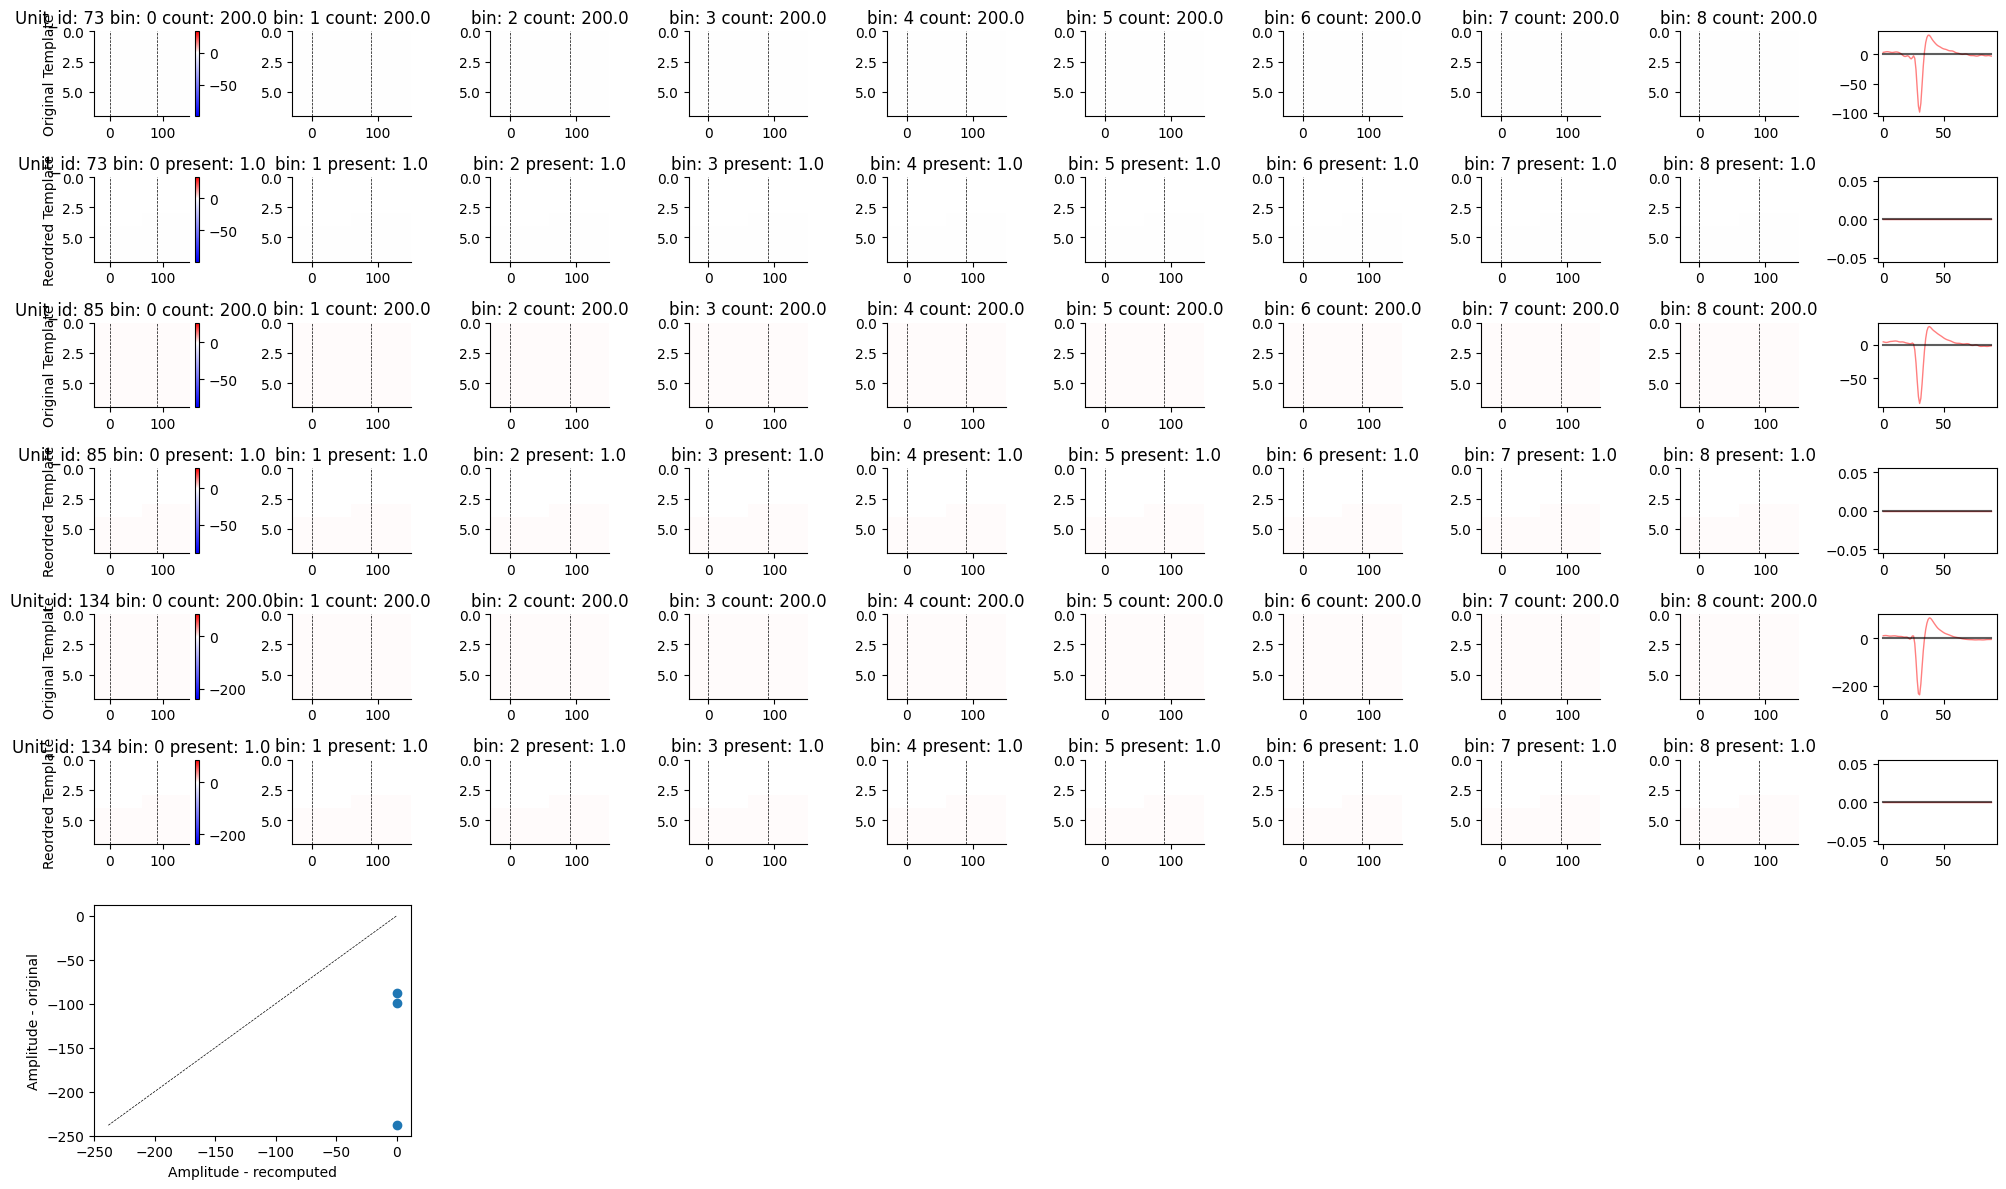

In [211]:
if plot: 
    fig = plt.figure(figsize=(20, 4*len(all_tagged_units)))
    gs = gridspec.GridSpec(2*len(all_tagged_units)+2, len(bin_inds)+1, figure=fig)
    for unit_ind, unit_id in enumerate(all_tagged_units):
        ax_wf_ori = fig.add_subplot(gs[unit_ind*2, len(bin_inds)])
        ax_wf_reo = fig.add_subplot(gs[unit_ind*2+1, len(bin_inds)])
        temp_mean_curr = temp_ext_mean.get_unit_template(unit_id, operator='average') 
        peak_mean_curr = temp_mean_curr[:,extreme_channel_indices[unit_id]]
        ax_wf_ori.plot(peak_mean_curr[60:150], color='r', alpha=0.5, linewidth=1)  
        ax_wf_reo.plot(all_peak_wf_opt[unit_ind], color='r', alpha=0.5, linewidth=1)

        all_temps_bins = all_wfs[unit_ind]
        all_temps_bins_ori = all_wfs_ori[unit_ind]  
        all_peak_bins = all_peak_wf[unit_ind]
        all_peak_bins_ori = all_peak_wf_ori[unit_ind]  
        # find min and mac of all templates
        min_reo = np.nanmin(np.array(all_temps_bins))
        max_reo = np.nanmax(np.array(all_temps_bins))
        min_ori = np.nanmin(np.array(all_temps_bins_ori))
        max_ori = np.nanmax(np.array(all_temps_bins_ori))
        min_all = min(min_reo, min_ori)
        max_all = max(max_reo, max_ori)
        if max_all == 0:
            max_all = np.nanmax(peak_mean_curr)
        if min_all == 0:
            min_all = np.nanmin(peak_mean_curr)
        
        shifted_cmap = shiftedColorMap(b_w_r_cmap, min_all, max_all, 'shifted_b_w_r')
        for curr_ind in bin_inds:
            # original template
            ax = fig.add_subplot(gs[unit_ind*2, curr_ind])
            curr_temp = all_temps_bins_ori[curr_ind]
            im = ax.imshow(curr_temp, extent=[samples_to_keep[0], 
                                            samples_to_keep[0] + 2 * (samples_to_keep[1] - samples_to_keep[0]), 
                                            2 * y_neighbors_to_keep + 1, 0], 
                                            cmap=shifted_cmap, interpolation='nearest',
                                            vmin=min_all, vmax=max_all, aspect='auto')
            ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
            ax.axvline(samples_to_keep[1] - samples_to_keep[0], color='black', linestyle='--', linewidth=0.5)
            if curr_ind == 0:
                ax.set_title(f'Unit_id: {unit_id} bin: {curr_ind} count: {all_counts[unit_ind, curr_ind]}')
                fig.colorbar(im, ax=ax)
                ax.set_ylabel('Original Template')
            else:
                ax.set_title(f'bin: {curr_ind} count: {all_counts[unit_ind, curr_ind]}')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax_wf_ori.plot(all_peak_bins_ori[curr_ind], color='black', alpha=0.1)

            # reordered template
            ax = fig.add_subplot(gs[unit_ind*2+1, curr_ind])
            curr_temp = all_temps_bins[curr_ind]
            im = ax.imshow(curr_temp, extent=[samples_to_keep[0], 
                                            samples_to_keep[0] + 2 * (samples_to_keep[1] - samples_to_keep[0]), 
                                            2 * y_neighbors_to_keep + 1, 0], 
                                            cmap=shifted_cmap, interpolation='nearest',
                                            vmin=min_all, vmax=max_all, aspect='auto')
            ax.axvline(0, color='black', linestyle='--', linewidth=0.5)
            ax.axvline(samples_to_keep[1] - samples_to_keep[0], color='black', linestyle='--', linewidth=0.5)
            if curr_ind == 0:
                ax.set_title(f'Unit_id: {unit_id} bin: {curr_ind} present: {presence_score[unit_ind, curr_ind]}')
                fig.colorbar(im, ax=ax)
                ax.set_ylabel('Reordred Template')
            else:
                ax.set_title(f'bin: {curr_ind} present: {presence_score[unit_ind, curr_ind]}')
            ax.spines['top'].set_visible(False) 
            ax.spines['right'].set_visible(False)
            ax_wf_reo.plot(all_peak_bins[curr_ind], color='black', alpha=0.1)

    ax = fig.add_subplot(gs[2*len(all_tagged_units):, 0:2])
    ax.scatter(all_amp_opt, all_amps_ori)
    all_max = max(max(all_amps_ori), max(all_amp_opt))
    all_min = min(min(all_amps_ori), min(all_amp_opt))
    ax.plot([all_min, all_max], [all_min, all_max], color='black', linestyle='--', linewidth=0.5)
    ax.set_xlabel('Amplitude - recomputed')
    ax.set_ylabel('Amplitude - original')

plt.tight_layout()
fig.savefig(fname=f'{session_dir[f"ephys_dir_{data_type}"]}/waveforms_recompute.pdf')